<a href="https://colab.research.google.com/github/HimaniBali/MIMIC-/blob/main/MIMIC_Tutorial_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **MIMIC-III Data Analysis with Machine Learning**
## **Google Colab-Compatible Notebook**

This tutorial demonstrates **how to analyze MIMIC-III healthcare data** using **BigQuery, Machine Learning (ML), and Deep Learning (DL) models** in **Google Colab**.

### **🔹 Steps Covered:**
1. **Connect to Google BigQuery** to extract MIMIC-III data.
2. **Preprocess the dataset** (handle missing values, normalize, encode features).
3. **Train ML/DL models** for healthcare prediction tasks.
4. **Evaluate performance using metrics like AUC, F1-score, etc.**
5. **Visualize important features & results.**

---

### **💻 Prerequisites (Run This First)**
Before running the notebook, **enable Google Cloud BigQuery** and install required libraries:

```python
!pip install pandas numpy matplotlib seaborn tensorflow torch google-cloud-bigquery
!pip install -U google-colab
```

Then, restart your runtime to ensure all packages are correctly loaded.


In [ ]:

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from google.cloud import bigquery
from google.colab import auth

# Authenticate Google account for BigQuery
auth.authenticate_user()
print("Authentication successful!")

# Connect to BigQuery
client = bigquery.Client()


Authentication successful!


In [ ]:
from google.cloud import bigquery

# Set your Google Cloud Project ID
project_id = "extreme-voice-231807"  # Replace with your actual project ID

# Initialize BigQuery Client
client = bigquery.Client(project=project_id)

print(f"✅ BigQuery Client Connected to Project: {project_id}")


✅ BigQuery Client Connected to Project: extreme-voice-231807


In [ ]:
# List datasets available in your project
datasets = list(client.list_datasets())

print("\n📌 Accessible Datasets:")
for dataset in datasets:
    print(f"  - {dataset.dataset_id}")


📌 Accessible Datasets:


In [ ]:
# Get reference to the dataset
dataset_ref = client.get_dataset('physionet-data.mimiciii_clinical')

# List all tables in the dataset
tables = list(client.list_tables(dataset_ref))

print("\n📌 MIMIC-III Tables:")
for table in tables:
    print(f"  - {table.table_id}")



📌 MIMIC-III Tables:
  - admissions
  - callout
  - caregivers
  - chartevents
  - cptevents
  - d_cpt
  - d_icd_diagnoses
  - d_icd_procedures
  - d_items
  - d_labitems
  - datetimeevents
  - diagnoses_icd
  - drgcodes
  - icustays
  - inputevents_cv
  - inputevents_mv
  - labevents
  - microbiologyevents
  - outputevents
  - patients
  - prescriptions
  - procedureevents_mv
  - procedures_icd
  - services
  - transfers


In [ ]:
QUERY = '''
WITH hr_bp AS (
    SELECT ce.icustay_id,
           ce.itemid,
           ce.valuenum,
           ROW_NUMBER() OVER(PARTITION BY ce.icustay_id, ce.itemid ORDER BY ce.charttime DESC) AS rn
    FROM `physionet-data.mimiciii_clinical.chartevents` AS ce
    WHERE ce.itemid IN (220045, 220050) -- Heart Rate & Blood Pressure
    AND ce.valuenum IS NOT NULL
    AND ce.charttime IS NOT NULL
)
SELECT icu.subject_id,
       icu.hadm_id,
       icu.icustay_id,
       p.gender,
       DATE_DIFF(CAST(a.admittime AS DATE), CAST(p.dob AS DATE), YEAR) AS age,
       MAX(CASE WHEN hr_bp.itemid = 220045 THEN hr_bp.valuenum END) AS heart_rate,
       MAX(CASE WHEN hr_bp.itemid = 220050 THEN hr_bp.valuenum END) AS blood_pressure,
       a.hospital_expire_flag AS mortality
FROM `physionet-data.mimiciii_clinical.icustays` AS icu
JOIN `physionet-data.mimiciii_clinical.patients` AS p
    ON icu.subject_id = p.subject_id
JOIN `physionet-data.mimiciii_clinical.admissions` AS a
    ON icu.hadm_id = a.hadm_id
LEFT JOIN hr_bp ON icu.icustay_id = hr_bp.icustay_id AND hr_bp.rn = 1
GROUP BY icu.subject_id, icu.hadm_id, icu.icustay_id, p.gender, a.hospital_expire_flag, p.dob, a.admittime
LIMIT 5000
'''

# Execute Query
df = client.query(QUERY).to_dataframe()

# Display first few rows
df.head()





,subject_id,hadm_id,icustay_id,gender,age,heart_rate,blood_pressure,mortality
0,31183,130947,232622,M,84,NaN,NaN,0
1,87783,167128,284165,F,53,80.0,NaN,0
2,27123,140460,292564,F,72,109.0,NaN,0
3,31842,157527,232217,M,58,NaN,NaN,0
4,27112,164406,269479,M,53,92.0,159.0,0


# EXPLORATORY ANALYSIS

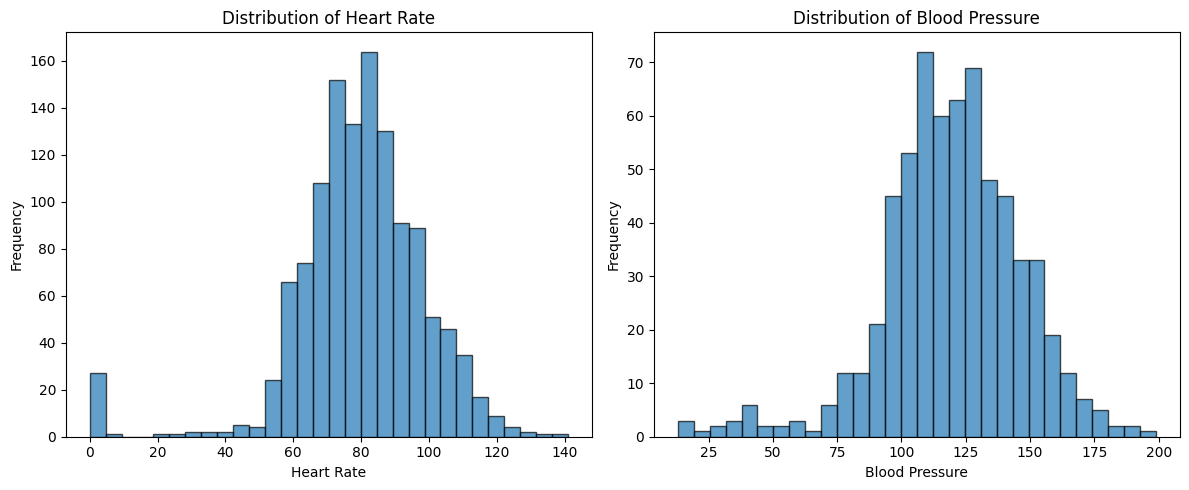

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset into a Pandas DataFrame (replace with actual loading code)
# df = pd.read_csv("your_dataset.csv")

# Plot histograms for heart rate and blood pressure
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['heart_rate'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Heart Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Heart Rate")

plt.subplot(1, 2, 2)
plt.hist(df['blood_pressure'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Blood Pressure")
plt.ylabel("Frequency")
plt.title("Distribution of Blood Pressure")

plt.tight_layout()
plt.show()


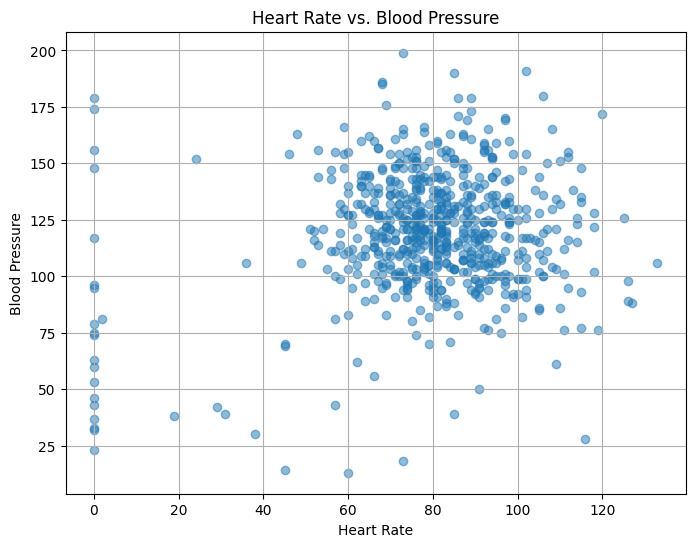

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['heart_rate'], df['blood_pressure'], alpha=0.5)
plt.xlabel("Heart Rate")
plt.ylabel("Blood Pressure")
plt.title("Heart Rate vs. Blood Pressure")
plt.grid(True)
plt.show()



# PREPROCESSING

In [ ]:
# Drop missing values
df.dropna(inplace=True)

# Encode categorical features
df['gender'] = df['gender'].map({'M': 0, 'F': 1})  # Encode gender (M=0, F=1)
df['mortality'] = df['mortality'].astype(int)  # Convert target variable to integer

# Define feature matrix X and target variable y
X = df.drop(columns=['mortality'])
y = df['mortality']

### LOGISTIC REGRESSION

In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split dataset into Train & Test sets (Apply Scaling After Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize continuous features (Fit on Train, Transform on Test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit & Transform on Training Set
X_test_scaled = scaler.transform(X_test)  # Transform only on Test Set

print("Preprocessing complete! Data ready for ML model training.")

# Train the Logistic Regression model
model = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced')  # Use balanced weights
model.fit(X_train_scaled, y_train)

# Make Predictions (Now on X_test)
y_pred = model.predict(X_test_scaled)

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Preprocessing complete! Data ready for ML model training.
Model Accuracy: 0.7829457364341085
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       113
           1       0.32      0.69      0.44        16

    accuracy                           0.78       129
   macro avg       0.64      0.74      0.65       129
weighted avg       0.87      0.78      0.81       129



Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6497 - loss: 0.6384 - val_accuracy: 0.8760 - val_loss: 0.4632
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8752 - loss: 0.5037 - val_accuracy: 0.8760 - val_loss: 0.3874
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8698 - loss: 0.4354 - val_accuracy: 0.8760 - val_loss: 0.3451
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8509 - loss: 0.4496 - val_accuracy: 0.8760 - val_loss: 0.3214
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8869 - loss: 0.3720 - val_accuracy: 0.8915 - val_loss: 0.2990
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8994 - loss: 0.3578 - val_accuracy: 0.9070 - val_loss: 0.2862
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8983 - loss: 0.3588 - val_accuracy: 0.9147 - val_loss: 0.2792
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8975 - loss: 0.3628 - val_accuracy: 0.9225 - val_loss

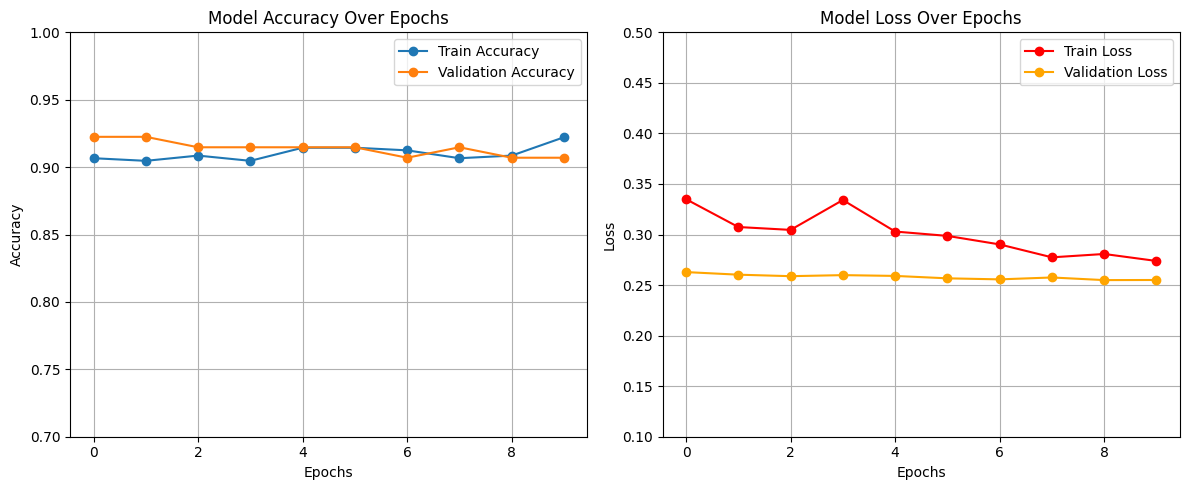

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Stratify ensures balanced class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Normalize continuous features (Fit on Train, Transform on Test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Convert target variable to float32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# ✅ Define the Deep Learning Model (Corrected Input Shape)
dl_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Correct input definition
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification (Mortality Prediction)
])

# Compile the Model
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
dl_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate Model
dl_loss, dl_accuracy = dl_model.evaluate(X_test_scaled, y_test)
print("Deep Learning Model Accuracy:", dl_accuracy)

# Train the Model
history = dl_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.ylim(0.7, 1)  # Set y-axis scale from 0 to 100
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0.1, 0.5)  # Set y-axis scale from 0 to 100

plt.title("Model Loss Over Epochs")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


